###**Andrew Renninger**
### Homework FIVE

**Packages**

In [0]:
import zipfile
import requests
import io
import numpy as np
from PIL import Image

#S1:
- Visit the EuroSAT data description page and download the data: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

Since we are using Colab rather than Jupyter, we are going to want to download the files directly before filtering out all folders and keeping the image files. Note that I split the data into training and test later, so my flow is not quite the same. 

In [2]:
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

request = requests.get(url)
files = zipfile.ZipFile(io.BytesIO(request.content))

images = []
for file in files.namelist():
  images.append(file)

images = [x for x in images if ".jpg" in x]

len(images)

27000

**More packages**

In [0]:
%matplotlib inline

from skimage.io import imread_collection
from skimage.io import imread

from skimage.color import rgb2gray

import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

import re

We can just test to see if this works by reading a few images and plotting them. 

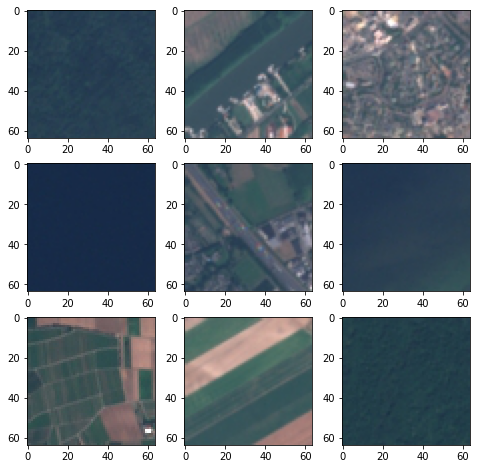

In [4]:
idx = np.random.randint(0, len(images), 9)

fig, axs = plt.subplots(3, 3, figsize = [8, 8])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      slot = i*3+j
      pic = images[idx[slot]]
      img = np.asarray(Image.open(files.open(pic))).astype('uint8')
      axs[i, j].imshow(img)
        
plt.show()

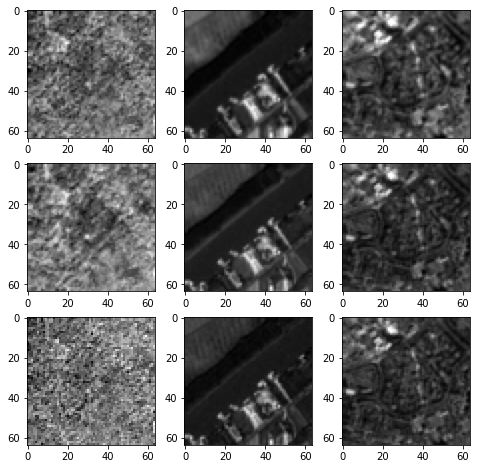

In [5]:
fig, axs = plt.subplots(3, 3, figsize = [8, 8])

for i in np.arange(0, 3):
    slot = i
    path = images[idx[slot]]
    for j in np.arange(0, 3):
      img = np.asarray(Image.open(files.open(path))).astype('uint8')
      axs[j, i].imshow(img[:,:, j], cmap = 'gray')
        
plt.show()

#S2:
- Convert each RBG image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)

- Implement a first deep learning model (M.1) using a fully connected network with a single fully connected layer (i.e: input layer + fully connected layer as the output layer).

- Q1: Calculate classification accuracy on the test data.

**This model achieves an accuracy of 0.125, so better than chance but not exactly worth celebrating.** 

In [0]:
def vectorize(img):
    mat = np.asarray(Image.open(files.open(img))).astype('uint8')
    bnw = rgb2gray(mat)
    out = bnw.squeeze().flatten()
    return out

Here I use a function to download images, convert them to greyscale, then flatten them. We loop through the 27000 images and insert the flattened vector into an array. I also needed to grab the labels so I did some string manipulations to extract them from the path and then create factors with them. As mentioned, below I split the data into shuffled train and test sets. 

In [0]:
series = pd.Series(images, name = "paths")
labels = series.str.split("/").str.get(1)

labels = pd.factorize(labels)

y = np.array(labels[0])

In [0]:
mat = np.asarray(Image.open(files.open(path))).astype('uint8')
bnw = rgb2gray(mat)
out = bnw.squeeze().flatten()

In [0]:
mat = np.zeros([y.shape[0], out.shape[0]])

for i, tmp in series.to_frame().iterrows():
    mat[i] = vectorize(tmp.paths)

We reshape the flattened greyscale images to make sure that everything worked.

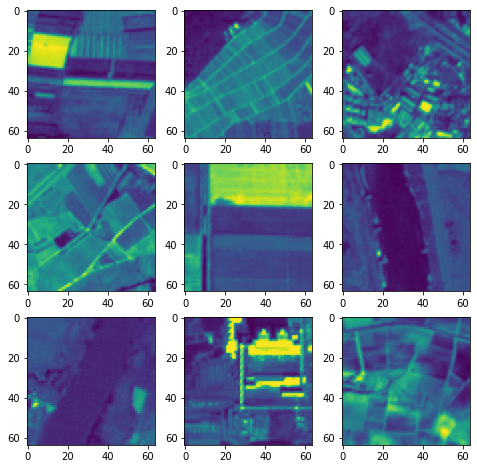

In [10]:
idx = np.random.randint(0, len(images), 9)

fig, axs = plt.subplots(3, 3, figsize = [8, 8])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      num = i*3+j
      dat = mat[idx[num]].reshape([64, 64])
      axs[i, j].imshow(dat)
        
plt.show()

In [0]:
from sklearn.model_selection import train_test_split

Here we create the training and testing data.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(mat, y, test_size = 0.5, random_state = 42)

The array of factors needs to become a matrix of binaries, and `keras` has a function for that.

In [13]:
from keras.utils import to_categorical

Using TensorFlow backend.


In [0]:
num_classes = len(labels[1])

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

This is note necessarily best practice but I wanted to experiment with batch sizes. These are a little big, and later on we use smaller ones with better results. 

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation, Dropout, Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D

EPOCH = 20
BATCH = int(y_train.shape[0] / EPOCH) 

We start with a simple model.

In [16]:
model_one = Sequential()
model_one.add(Dense(num_classes, activation = 'relu', input_shape = (4096,)))

model_one.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                40970     
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_one.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

history_one = model_one.fit(X_train, y_train,
                            epochs = EPOCH,
                            batch_size = BATCH,
                            validation_data = (X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/20
13500/13500 [==============================] - 1s 62us/step - loss: 11.2825 - accuracy: 0.1081 - val_loss: 11.4105 - val_accuracy: 0.1171
Epoch 2/20
13500/13500 [==============================] - 1s 42us/step - loss: 11.3685 - accuracy: 0.1147 - val_loss: 11.4099 - val_accuracy: 0.1191
Epoch 3/20
13500/13500 [==============================] - 1s 42us/step - loss: 11.3685 - accuracy: 0.1088 - val_loss: 11.4095 - val_accuracy: 0.1148
Epoch 4/20
13500/13500 [==============================] - 1s 42us/step - loss: 11.3685 - accuracy: 0.1080 - val_loss: 11.4118 - val_accuracy: 0.1092
Epoch 5/20
13500/13500 [==============================] - 1s 42us/step - loss: 11.3685 - accuracy: 0.1140 - val_loss: 11.4079 - val_accuracy: 0.1073
Epoch 6/20
13500/13500 [==============================] - 1s 42us/step - loss: 11.3672 - accuracy: 0.1127 - val_loss: 11.4104 - val_accuracy: 0.1136
Epoch 7/20
13500/13500 [==============================] 

In [18]:
score_one = model_one.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score_one[0])
print("Test accuracy: ", score_one[1])

Test loss:  11.405184213426377
Test accuracy:  0.14000000059604645


#S3:
- Implement a second deep learning model (M.2) adding an additional fully connected hidden layer (with an arbitrary number of nodes) to the previous model.

- Q1: Calculate classification accuracy on the test data.

**Here we get an accuracy of 0.154—better.**

In [19]:
model_two = Sequential()
model_two.add(Dense(500, activation = 'relu', input_shape = (4096,)))
model_two.add(Dense(num_classes, activation = 'relu'))

model_two.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 500)               2048500   
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5010      
Total params: 2,053,510
Trainable params: 2,053,510
Non-trainable params: 0
_________________________________________________________________


In [20]:
model_two.compile(optimizer = 'rmsprop',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

history_two = model_two.fit(X_train, y_train,
                            epochs = EPOCH,
                            batch_size = BATCH,
                            validation_data = (X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/20
13500/13500 [==============================] - 1s 62us/step - loss: 6.8462 - accuracy: 0.0921 - val_loss: 6.3922 - val_accuracy: 0.0930
Epoch 2/20
13500/13500 [==============================] - 1s 55us/step - loss: 6.4270 - accuracy: 0.1044 - val_loss: 6.3802 - val_accuracy: 0.1093
Epoch 3/20
13500/13500 [==============================] - 1s 55us/step - loss: 6.4223 - accuracy: 0.1123 - val_loss: 6.3805 - val_accuracy: 0.1136
Epoch 4/20
13500/13500 [==============================] - 1s 55us/step - loss: 6.4216 - accuracy: 0.1128 - val_loss: 6.3777 - val_accuracy: 0.1095
Epoch 5/20
13500/13500 [==============================] - 1s 55us/step - loss: 6.4205 - accuracy: 0.1141 - val_loss: 6.3725 - val_accuracy: 0.1099
Epoch 6/20
13500/13500 [==============================] - 1s 54us/step - loss: 6.4162 - accuracy: 0.1209 - val_loss: 6.3773 - val_accuracy: 0.1147
Epoch 7/20
13500/13500 [==============================] - 1s 54us/st

In [21]:
score_two = model_two.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score_two[0])
print("Test accuracy: ", score_two[1])

Test loss:  3.7091776503103753
Test accuracy:  0.15355555713176727


#S4:
- Implement a third deep learning model (M.3) adding two additional fully connected hidden layers (with arbitrary number of nodes) as well as drop-out layers to the previous model.

- Q1: Calculate classification accuracy on the test data.

**Slightly better at 0.175**

- Q2: Compare against previous models. Which model was the "best"? Why?

**When we consider the loss and accuracy, the third model is best. It trades modest additions of time for modest improvements to prediction, however. The graph below plots the loss of each model across epochs and the first two show wild variation while the last is consistent—another reason to choose this model over the others.** 

In [22]:
model_tre = Sequential()
model_tre.add(Dense(500, activation = 'relu', input_shape = (4096,)))
model_tre.add(Dropout(0.3))
model_tre.add(Dense(300, activation = 'relu'))
model_tre.add(Dropout(0.3))
model_tre.add(Dense(100, activation = 'relu'))
model_tre.add(Dropout(0.3))
model_tre.add(Dense(num_classes, activation = 'relu'))

model_tre.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 500)               2048500   
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 300)               150300    
_________________________________________________________________
dropout_2 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               30100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

In [23]:
model_tre.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

history_tre = model_tre.fit(X_train, y_train,
                            epochs = EPOCH,
                            batch_size = BATCH,
                            validation_data = (X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/20
13500/13500 [==============================] - 1s 74us/step - loss: 2.9381 - accuracy: 0.1053 - val_loss: 2.2995 - val_accuracy: 0.1092
Epoch 2/20
13500/13500 [==============================] - 1s 61us/step - loss: 2.3432 - accuracy: 0.1058 - val_loss: 2.2955 - val_accuracy: 0.1093
Epoch 3/20
13500/13500 [==============================] - 1s 61us/step - loss: 2.3240 - accuracy: 0.1139 - val_loss: 2.2947 - val_accuracy: 0.1098
Epoch 4/20
13500/13500 [==============================] - 1s 60us/step - loss: 2.3160 - accuracy: 0.1084 - val_loss: 2.2940 - val_accuracy: 0.1092
Epoch 5/20
13500/13500 [==============================] - 1s 60us/step - loss: 2.3128 - accuracy: 0.1061 - val_loss: 2.2938 - val_accuracy: 0.1093
Epoch 6/20
13500/13500 [==============================] - 1s 61us/step - loss: 2.3102 - accuracy: 0.1028 - val_loss: 2.2932 - val_accuracy: 0.1124
Epoch 7/20
13500/13500 [==============================] - 1s 61us/st

In [24]:
score_tre = model_tre.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score_tre[0])
print("Test accuracy: ", score_tre[1])

Test loss:  2.1685668930477564
Test accuracy:  0.1715555489063263


We can compare all of the models at once by plotting the loss. 

In [0]:
epochs = range(1, EPOCH + 1)

one_val_loss = history_one.history['val_loss']
two_val_loss = history_two.history['val_loss']
tre_val_loss = history_tre.history['val_loss']

one_train_loss = history_one.history['loss']
two_train_loss = history_two.history['loss']
tre_train_loss = history_tre.history['loss']

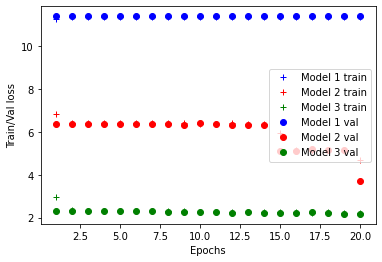

In [26]:
plt.plot(epochs, one_train_loss, 'b+', label = 'Model 1 train')
plt.plot(epochs, two_train_loss, 'r+', label = 'Model 2 train')
plt.plot(epochs, tre_train_loss, 'g+', label = 'Model 3 train')
plt.plot(epochs, one_val_loss, 'bo', label = 'Model 1 val')
plt.plot(epochs, two_val_loss, 'ro', label = 'Model 2 val')
plt.plot(epochs, tre_val_loss, 'go', label = 'Model 3 val')

plt.xlabel('Epochs')
plt.ylabel('Train/Val loss')
plt.legend()

plt.show()

#S5:
- Using RGB images (without vectorizing them), implement a fourth CNN model (M.4) that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense.

- Q1: Calculate classification accuracy on the test data.

**This time we see accuracy of 0.656, much gained.**

- Q2: Compare against previous models. Which model was the "best"? Why?

**Taking two dimensions rather than three, we see obvious improvements to the model. As before, we trade time for accuracy, but in this instance with far larger effects. Because we see such gains in accuracy, the convolutions are worth it.**

In [0]:
def colorize(img):
    out = np.asarray(Image.open(files.open(img))).astype('uint8')
    return out

In [0]:
test = np.asarray(Image.open(files.open(path))).astype('uint8')

In [0]:
mat = np.zeros([y.shape[0], test.shape[0], test.shape[1], test.shape[2]])

for i, tmp in series.to_frame().iterrows():
    mat[i] = colorize(tmp.paths)
    
mat = mat.astype('uint8')

We can plot a few images by band to see if they arrived in one piece. 

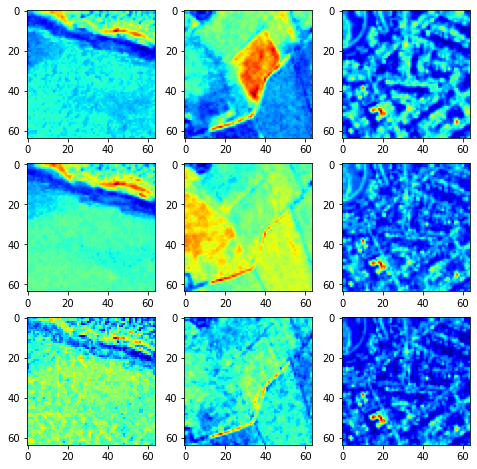

In [30]:
idx = np.random.randint(0, 27001, 9)

fig, axs = plt.subplots(3, 3, figsize = [8, 8])

for i in np.arange(0, 3):
    slot = i
    for j in np.arange(0, 3):
        img = mat[idx[slot]]
        axs[j, i].imshow(img[:,:, j], cmap = 'jet')
        
plt.show()

Note that here we divide by 255 to rescale the bands. 

In [0]:
X = mat / 255

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=42)

num_classes = len(labels[1])

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

This model has a few dropout layers to limit overfitting but keeps convolutions to a minimum to save time. 

In [0]:
model = Sequential()

model.add(Conv2D(32, kernel_size = (3, 3),
                 activation = 'relu',
                 input_shape = mat.shape[1:]))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation = 'softmax'))

In [0]:
from keras.optimizers import SGD

This time, we can experiment with a *stochastic gradient descent* optimizer. 

In [0]:
sgd = SGD(lr = 0.01, momentum = 0.9, nesterov = True)

model.compile(loss = 'categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

In [35]:
model.fit(X_train, y_train,
          epochs = EPOCH,
          batch_size = BATCH,
          validation_data = (X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/20
13500/13500 [==============================] - 12s 889us/step - loss: 2.2013 - accuracy: 0.1520 - val_loss: 2.0007 - val_accuracy: 0.2792
Epoch 2/20
13500/13500 [==============================] - 9s 679us/step - loss: 2.0352 - accuracy: 0.2337 - val_loss: 1.7705 - val_accuracy: 0.3376
Epoch 3/20
13500/13500 [==============================] - 9s 680us/step - loss: 1.8162 - accuracy: 0.3029 - val_loss: 1.7321 - val_accuracy: 0.3176
Epoch 4/20
13500/13500 [==============================] - 9s 678us/step - loss: 1.8272 - accuracy: 0.2998 - val_loss: 1.7431 - val_accuracy: 0.3667
Epoch 5/20
13500/13500 [==============================] - 9s 677us/step - loss: 1.7878 - accuracy: 0.3137 - val_loss: 1.6473 - val_accuracy: 0.4111
Epoch 6/20
13500/13500 [==============================] - 9s 676us/step - loss: 1.6796 - accuracy: 0.3776 - val_loss: 1.5875 - val_accuracy: 0.4399
Epoch 7/20
13500/13500 [==============================] - 9s 

In [36]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  1.2521956047481961
Test accuracy:  0.5571110844612122


#S6:
- Using RGB images (without vectorizing them), implement a fifth deep learning model (M.5) targeting accuracy that will outperform all previous models. You are free to use any tools and techniques, as well as pre-trained models for transfer learning.

- Q1: Describe the model you built, and why you chose it.

**I wanted to use to VGG16, a pretrained model, but rather than just use the package, I thought I would copy the code so I could see the layers and its inner workings. This model is far deeper: the EuroSAT paper, which benchmarks these predictions, mentions that convolutional neural networks perform well but deeper ones do better than shallower ones, so to test that hypothesis, I wanted to add several levels. VGG16 serves that function well, because it limits hyperparameters—easier to work through—with a standard 3 by 3 convolution and 2 by 2 max pooling.**

- Q2: Calculate classification accuracy on the test data.

**Outstripping the rest with accuracy 0.767.**

- Q3: Compare against previous models. Which model was the "best"? Why?

**A few interesting things occurred during the modeling. In the early epochs, testing accuracy stagnated as training accuracy climbed. This suggests that we were titrating to a limit and there was little to gain by adding epochs. Each epoch took far more time than the other models, but it did achieve the highest prediction accuracy so far so it paid off. This model perform best.**

- Q4: What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.

**The most common misclassifications come from pastures and vegetation. This is not surprsing, given that even to the human eye, they are similar—though it would have been nice to create model that could pick up on more than the human eye could. Plotting images, we can see just how similar they are. We can see in the confusion matrix that, oddly enough, permanent crop is often confused, annual crop rarely so. Yet when we dig into the data, this is driven by the fact that there are more annual crop images than permanent crop ones: they raw misclassification numbers are similar. The true confusion comes from pasture and vegation, and when we plot histograms of each band—red, green and blue—for each one, we can see they quite similar spectral signatures. These and highways—another commonly missed prediction—all have a right skew to their distributions.**

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

Here, we copy the specifications of VGG16, expanding convolutional layers before collapsing back with dense layers; as its name suggests, it has 16 weighted layers.

In [0]:
model = Sequential()

model.add(ZeroPadding2D((1,1), input_shape = mat.shape[1:]))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2,2), strides = (2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

This model takes longer than any of the others. 

In [40]:
model.fit(X_train, y_train,
          epochs = EPOCH,
          batch_size = 32,
          validation_data = (X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/20
13500/13500 [==============================] - 83s 6ms/step - loss: 2.2924 - accuracy: 0.1234 - val_loss: 2.2964 - val_accuracy: 0.1092
Epoch 2/20
13500/13500 [==============================] - 80s 6ms/step - loss: 2.2912 - accuracy: 0.1178 - val_loss: 2.2123 - val_accuracy: 0.1934
Epoch 3/20
13500/13500 [==============================] - 80s 6ms/step - loss: 1.8575 - accuracy: 0.2538 - val_loss: 1.5665 - val_accuracy: 0.3600
Epoch 4/20
13500/13500 [==============================] - 80s 6ms/step - loss: 1.4259 - accuracy: 0.4552 - val_loss: 1.1880 - val_accuracy: 0.5667
Epoch 5/20
13500/13500 [==============================] - 80s 6ms/step - loss: 1.1051 - accuracy: 0.5915 - val_loss: 1.0402 - val_accuracy: 0.6311
Epoch 6/20
13500/13500 [==============================] - 80s 6ms/step - loss: 0.9499 - accuracy: 0.6522 - val_loss: 0.8141 - val_accuracy: 0.7016
Epoch 7/20
13500/13500 [==============================] - 80s 6ms/st

In [41]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  1.078919204102622
Test accuracy:  0.7400000095367432


The table below shows the classification results by category. Some appear easy to the model, others much harder. 

In [42]:
y_real = np.argmax(y_test, axis = 1)
y_pred = model.predict_classes(X_test)

score = y_real == y_pred

scoreboard = pd.DataFrame({"real": y_real, "score": score}).groupby(["real"], as_index = False).agg({"score": ['count', 'sum']})
scoreboard.score.assign(rate = scoreboard.score['sum'] / scoreboard.score['count']).assign(label = labels[1])

,count,sum,rate,label
0,1224,842.0,0.687908,River
1,1533,1366.0,0.891063,AnnualCrop
2,1517,871.0,0.574160,HerbaceousVegetation
3,1255,1006.0,0.801594,Industrial
4,1474,1385.0,0.939620,Residential
5,1301,657.0,0.504996,Highway
6,965,513.0,0.531606,Pasture
7,1532,1193.0,0.778721,Forest
8,1475,1397.0,0.947119,SeaLake
9,1224,760.0,0.620915,PermanentCrop


We can show a few images to see what is going on. 

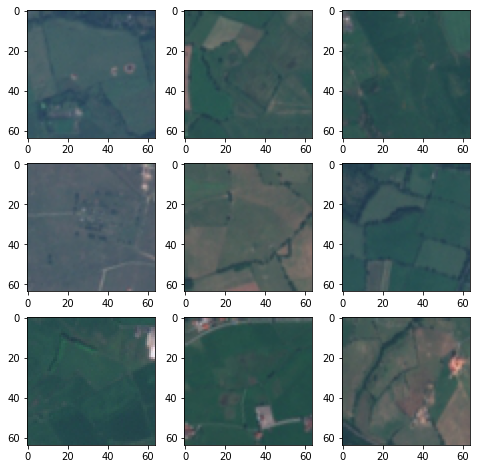

In [43]:
pastures = X_test[score & (y_real == 6)]

idx = np.random.randint(0, len(pastures), 9)

fig, axs = plt.subplots(3, 3, figsize = [8, 8])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      slot = i*3+j
      img = pastures[idx[slot]]
      axs[i, j].imshow(img)
        
plt.show()

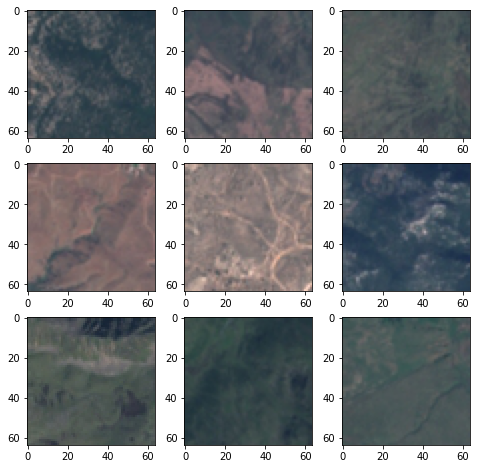

In [44]:
vegation = X_test[score & (y_real == 2)]

idx = np.random.randint(0, len(vegation), 9)

fig, axs = plt.subplots(3, 3, figsize = [8, 8])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      slot = i*3+j
      img = vegation[idx[slot]]
      axs[i, j].imshow(img)
        
plt.show()

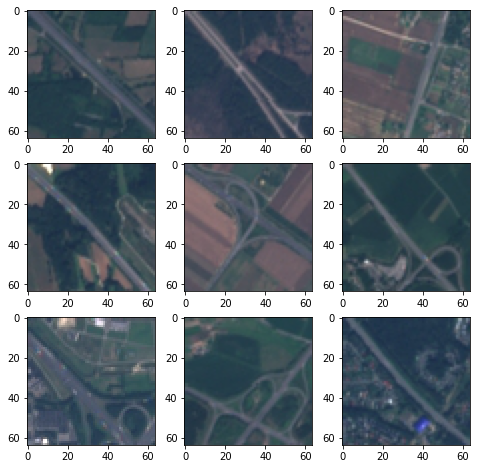

In [90]:
highways = X_test[score & (y_real == 5)]

idx = np.random.randint(0, len(highways), 9)

fig, axs = plt.subplots(3, 3, figsize = [8, 8])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
      slot = i*3+j
      img = highways[idx[slot]]
      axs[i, j].imshow(img)
        
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix

To make a better confusion matrix, we can use `pyplot`, which allows us to make tiled images to represent the number of cases in each quadrant and then annotate it. 

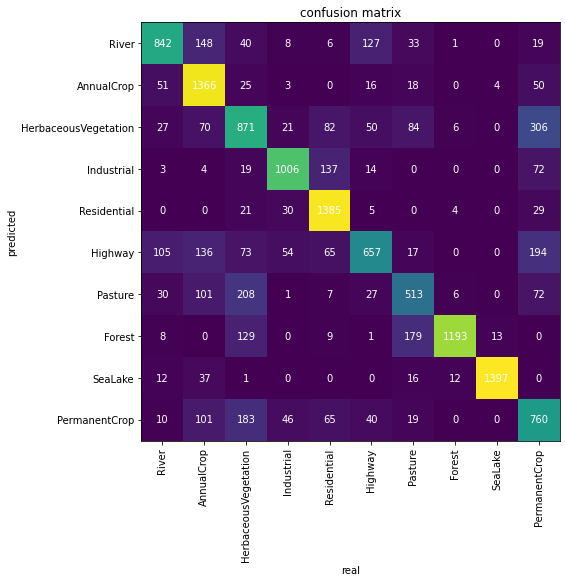

In [88]:
cm = confusion_matrix(y_real, y_pred)

fig, ax = plt.subplots(figsize = [8, 8])
im = ax.imshow(cm)

ax.set_xticks(np.arange(len(np.unique(y_real))))
ax.set_yticks(np.arange(len(np.unique(y_pred))))
ax.set_xticklabels(np.array(labels[1]), rotation = 90)
ax.set_yticklabels(np.array(labels[1]))

for i in range(len(np.unique(y_real))):
    for j in range(len(np.unique(y_pred))):
        text = ax.text(j, i, cm[i, j],
                       ha="center", va="center", color="w")

ax.set_title("confusion matrix")
fig.tight_layout()

plt.xlabel('real')
plt.ylabel('predicted')
plt.show()

The histograms really shows how similar the three classes are. 

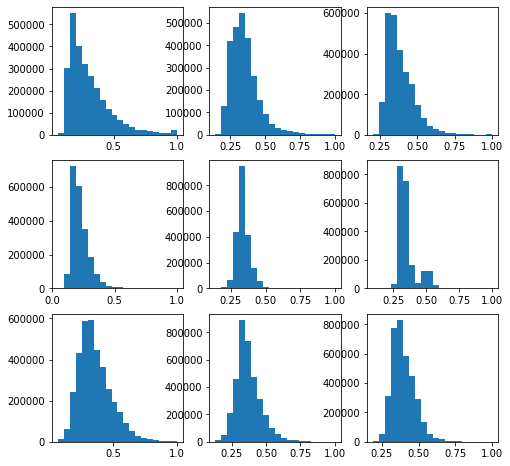

In [91]:
cats = np.asarray([highways, pastures, vegation])
bins = 20

fig, axs = plt.subplots(3, 3, figsize = [8, 8])

for i in np.arange(0, 3):
  category = cats[i]
  for j in np.arange(0, 3):
    band = category[:, :, :, j].flatten()
    axs[i, j].hist(band, bins = 20)
        
plt.show()

S7:
- Apply your best model on multispectral images.
- Q1: Calculate classification accuracy on the test data.

**The classification accuracy, which above topped out above 70, is now around chance, at 0.111.**

- Q2: Compare against results using RGB images.

**Paradoxically, using more data—in the form of more bands—produced poor results. When we compare this to the other models, plotting the data sheds light on the issue. The multispectral image needs a fair amount of cleaning and, although I tried a few techniques, none produced results. It also might benefit from sharpening. These steps would take further research.**

In [0]:
pip install tifffile

This requires new packages to read in the data.

In [0]:
import tifffile as tiff

In [94]:
url = 'http://madm.dfki.de/files/sentinel/EuroSATallBands.zip'

request = requests.get(url)
files = zipfile.ZipFile(io.BytesIO(request.content))

images = []
for file in files.namelist():
  images.append(file)

images = [x for x in images if ".tif" in x]

len(images)

27000

To see about preprocessing the data, I imported this function to trim the extremes by percentile. 

In [0]:
def scaleImgPerc(imgIn):
    w, h, d = imgIn.shape
    imgIn = np.reshape(imgIn, [w * h, d]).astype(np.float64)
    mins = np.percentile(imgIn, 1, axis=0)
    maxs = np.percentile(imgIn, 99, axis=0) - mins
    imgIn = (imgIn - mins[None, :]) / maxs[None, :]
    imgIn = np.reshape(imgIn, [w, h, d])
    imgIn = imgIn.clip(0, 1)
    return imgIn

Even with processing, the images are still less crisp then those from earlier. 

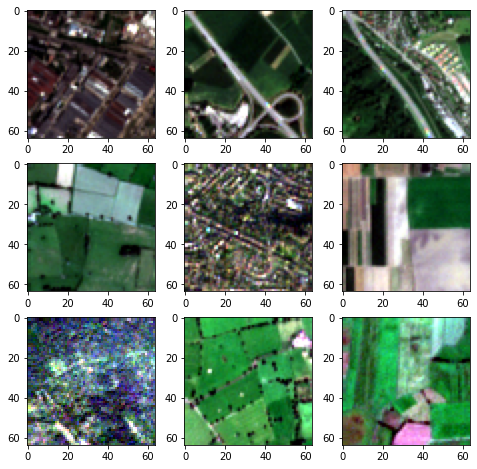

In [96]:
idx = np.random.randint(0, len(images), 9)

fig, axs = plt.subplots(3, 3, figsize = [8, 8])

for i in np.arange(0, 3):
    for j in np.arange(0, 3):
        slot = i*3+j
        path = images[idx[slot]]
        img = tiff.imread(files.extract(path))
        img = img[:, :, (3, 2, 1)]
        img = scaleImgPerc(img)
        axs[i, j].imshow(img)
        
plt.show()

Because NIR and SWIR are used in remote sensing to create indexes for built and natural environment, I decided to pull them in. Further feature engineering could actually include those indexes. 

In [0]:
series = pd.Series(images, name = "paths")
labels = series.str.split("/").str.get(6)

labels = pd.factorize(labels)

y = np.array(labels[0])

bands = (1, 2, 3, 7, 10, 11)

In experimenting with the multispectral imagery, I tested different techniques for cleaning up the data with no success, so I ended up foregoing scaling the data. 

In [0]:
def multibandize(img, bands):
    new = tiff.imread(files.extract(path))
    img = new[:, :, bands]
    out = scaleImgPerc(img)
    return out

In [0]:
def multibandize(img, bands):
    new = tiff.imread(files.extract(path))
    out = new[:, :, bands]
    return out

We use a test image to grab the dimensions.



In [0]:
test = multibandize(path, bands)

In [0]:
mat = np.zeros([y.shape[0], test.shape[0], test.shape[1], test.shape[2]])

for i, tmp in series.to_frame().iterrows():
  mat[i] = multibandize(tmp.paths, bands)

mat = mat.astype('uint8')

The multispectral data still splits in the same manner. 

In [0]:
X = mat

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=42)

num_classes = len(labels[1])

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

We use the same model as above.

In [0]:
model = Sequential()

model.add(ZeroPadding2D((1,1), input_shape = mat.shape[1:]))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2,2), strides = (2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(256, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))

model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(512, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2,2), strides = (2,2)))

model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

In [0]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = sgd,
              metrics = ['accuracy'])

In [106]:
model.fit(X_train, y_train,
          epochs = EPOCH,
          batch_size = 32,
          validation_data = (X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/20
13500/13500 [==============================] - 80s 6ms/step - loss: 2.2996 - accuracy: 0.1104 - val_loss: 2.2950 - val_accuracy: 0.1141
Epoch 2/20
13500/13500 [==============================] - 80s 6ms/step - loss: 2.2978 - accuracy: 0.1064 - val_loss: 2.2953 - val_accuracy: 0.1141
Epoch 3/20
13500/13500 [==============================] - 80s 6ms/step - loss: 2.2980 - accuracy: 0.1068 - val_loss: 2.2954 - val_accuracy: 0.1141
Epoch 4/20
13500/13500 [==============================] - 79s 6ms/step - loss: 2.2981 - accuracy: 0.1104 - val_loss: 2.2956 - val_accuracy: 0.1093
Epoch 5/20
13500/13500 [==============================] - 79s 6ms/step - loss: 2.2977 - accuracy: 0.1094 - val_loss: 2.2945 - val_accuracy: 0.1093
Epoch 6/20
13500/13500 [==============================] - 79s 6ms/step - loss: 2.2978 - accuracy: 0.1105 - val_loss: 2.2952 - val_accuracy: 0.1093
Epoch 7/20
13500/13500 [==============================] - 79s 6ms/st

Across all epochs, it failed to predict accurately. 

In [107]:
score = model.evaluate(X_test, y_test, verbose = 0)

print("Test loss: ", score[0])
print("Test accuracy: ", score[1])

Test loss:  2.2937076437914814
Test accuracy:  0.10925926268100739
